In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

df = pd.read_pickle("../data/KOSPI_price_2011-2021.pickle")
df

Open  High   Low   Close   Volume      Change
Name     Date                                                     
AJ네트웍스   2015-08-21  6180  7300  5600  7100.0  1994022         NaN
         2015-08-24  6700  6940  6240  6480.0   392831   -0.087324
         2015-08-25  6610  6730  6189  6220.0   242730   -0.040123
         2015-08-26  6260  7760  6260  7090.0   703721    0.139871
         2015-08-27  7239  8060  6960  7570.0   499913    0.067701
...                   ...   ...   ...     ...      ...         ...
흥아해운 14R 2018-01-02    60   158    51   158.0  1991440  158.000000
         2018-01-03   127   158   127   155.0  1112688   -3.000000
         2018-01-04   150   160   147   156.0  1014035    1.000000
         2018-01-05   151   161   151   160.0   922447    4.000000
         2018-01-08   157   164   157   161.0  1088127    1.000000

[3008276 rows x 6 columns]

In [2]:
idx = pd.IndexSlice
filtered_df = df.loc[idx[:, "2020-01-01":"2020-01-31"], :]
filtered_df

Open  High   Low   Close  Volume    Change
Name   Date                                                  
AJ네트웍스 2020-01-02  4900  5140  4895  5050.0  210107  0.016097
       2020-01-03  5050  5150  5030  5100.0  128274  0.009901
       2020-01-06  5080  5080  4950  5030.0  162087 -0.013725
       2020-01-07  5030  5100  4965  5030.0   42008  0.000000
       2020-01-08  5050  5060  4735  4935.0  110827 -0.018887
...                 ...   ...   ...     ...     ...       ...
흥아해운   2020-01-23  2651  2687  2615  2622.0  138273 -0.020179
       2020-01-28  2523  2578  2457  2562.0  231323 -0.022883
       2020-01-29  2559  2639  2517  2537.0  118889 -0.009758
       2020-01-30  2559  2571  2361  2459.0  155956 -0.030745
       2020-01-31  2457  2493  2385  2411.0  138349 -0.019520

[29447 rows x 6 columns]

In [3]:
R = filtered_df.reset_index().groupby("Name")['Change'].mean().to_numpy() * 252
V = filtered_df.reset_index().pivot(index='Date', columns='Name', values='Change').cov().to_numpy() * 252 
print(f"R: {len(R)} and V: {len(V)}")
np.sum(V == np.nan)

R: 1475 and V: 1475


0

In [4]:
class RiskParity:
    def __init__(self, cov_mat):
        
        # 일평균 수익률을 연 단위로 환산한 후, 이때의 공분산
#         self.cov_mat = data.reset_index().pivot(index='Date', columns='Name', values='Change').cov().to_numpy() * 252 
        self.cov_mat = cov_mat
        self.initial_weights = np.repeat(1 / self.cov_mat.shape[0], self.cov_mat.shape[0])
        self.constraints = ({"type": "eq", "fun": RiskParity.weight_summation_constraint,
                            "type": "ineq", "fun": RiskParity.weight_bound_constraint})
        self.options = {"ftol": 1e-20, "maxiter": 1000}
        
        
    def optimize(self):
        self.results = minimize(fun=RiskParity.objective_function,
                                x0=self.initial_weights, 
                                method='SLSQP', 
                                constraints=self.constraints,
                                options=self.options,
                                args=self.cov_mat)

        
    @staticmethod
    def objective_function(x, cov_mat):
        variance = x.T @ cov_mat @ x
        sigma = variance ** 0.5
        mrc = 1 / sigma * (cov_mat @ x)
        rc = x * mrc
        a = np.reshape(rc, (len(rc), 1))
        risk_diff = a - a.T
        squared_risk_diff_summation = np.sum(np.square(np.ravel(risk_diff)))

        return squared_risk_diff_summation


    @staticmethod
    def weight_summation_constraint(x):
        return x.sum() - 1.0


    @staticmethod
    def weight_bound_constraint(x):
        return x      

/var/folders/nw/x1lqw0rx1mj698bqcgqxhk880000gn/T/ipykernel_11033/4233283657.py:25: RuntimeWarning: invalid value encountered in double_scalars
  sigma = variance ** 0.5


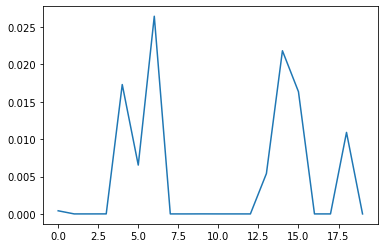

In [5]:
cov_mat = np.random.normal(size=400).reshape((20, 20))
risk_parity = RiskParity(cov_mat)
risk_parity.optimize()

plt.plot(risk_parity.results.x)

- http://henryquant.blogspot.com/2017/08/risk-parity-python-code.html
- https://thequantmba.wordpress.com/2016/12/14/risk-parityrisk-budgeting-portfolio-in-python/
- https://stackoverflow.com/questions/38218975/how-to-solve-risk-parity-allocation-using-python